In [81]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import shap
import numpy as np
import joblib
import json

# Model Training with Material Data

## Data Preparation

In [23]:
file_path = '../data/processed/inventory.csv'
data = pd.read_csv(file_path)

In [24]:
data = data[data['Type'] == 'Material']
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

In [25]:
data['Material Code'] = data['Material Code'].astype(str)
data = data.dropna(subset=['Material Issued', 'Open Stock', 'Closing Stock'])

In [26]:
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

In [27]:
# Add 1-day Lag Feature
data['Lag_1_Issued'] = data.groupby('Material Code')['Material Issued'].shift(1)

# Add 7-day Rolling Statistics
data['Rolling_7_Issued'] = data.groupby('Material Code')['Material Issued'].rolling(7).mean().reset_index(level=0, drop=True)

# Add Seasonality Indicator (e.g., Weekday)
data['Weekday'] = data['Date'].dt.weekday  # 0=Monday, 6=Sunday

# Fill NaN values introduced by lagging and rolling
data.fillna(0, inplace=True)

In [28]:
# Encode Material Code as a categorical feature
encoder = LabelEncoder()
data['Material Code Encoded'] = encoder.fit_transform(data['Material Code'])

In [29]:
# Target and Features
features = ['Open Stock', 'Closing Stock', 'Day', 'Month', 'Year', 'Material Code Encoded', 'Lag_1_Issued', 'Rolling_7_Issued', 'Weekday', 'BFP']
X = data[features]
y = data['Material Issued']

In [30]:
# Time-based split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Random Forest

In [31]:
# Read JSON file
with open('./best_params/rf_material.json', 'r') as file:
    rf_param = json.load(file)

In [32]:
model_rf = RandomForestRegressor(**rf_param)

In [33]:
model_rf.fit(X_train, y_train)
predictions = model_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Best Model RMSE: {rmse}")

Best Model RMSE: 235.20675370266548


In [35]:
# Save the model as a .pkl file
model_path = "./trained_models/rf_model_material.pkl"
joblib.dump(model_rf, model_path)


['./trained_models/rf_model_material.pkl']

#### Random Forest Shapley

The provided SHAP (SHapley Additive exPlanations) summary plot illustrates the impact of various features on the model's output. The features are listed on the y-axis, while the x-axis represents the SHAP value, indicating the impact on the model's prediction. Each point on the plot corresponds to an individual prediction, with colors ranging from low (blue) to high (red) feature values.

From the plot, it is evident that the `Rolling_7_Issued` feature has the most significant impact on the model's output, with a wide range of SHAP values extending both positively and negatively. Higher values of this feature (red points) tend to have a more substantial positive impact. The `Lag_1_Issued` feature also shows a notable influence, with higher values generally contributing positively to the predictions. The `Weekday` feature demonstrates a varied impact, with certain days having a more pronounced effect than others.

The `Open Stock` and `Closing Stock` features exhibit moderate impacts, with higher values of `Open Stock` generally leading to higher SHAP values. Temporal features such as `Day`, `Month`, and `Year` show relatively smaller impacts, clustered around the zero SHAP value, indicating lesser influence on the model's predictions. The `Material Code Encoded` and `BFP` features also have minimal impact, with their SHAP values closely centered around zero.

Overall, the plot highlights that features related to issued quantities and stock levels are more influential in the model's decision-making process compared to temporal and encoded material features.

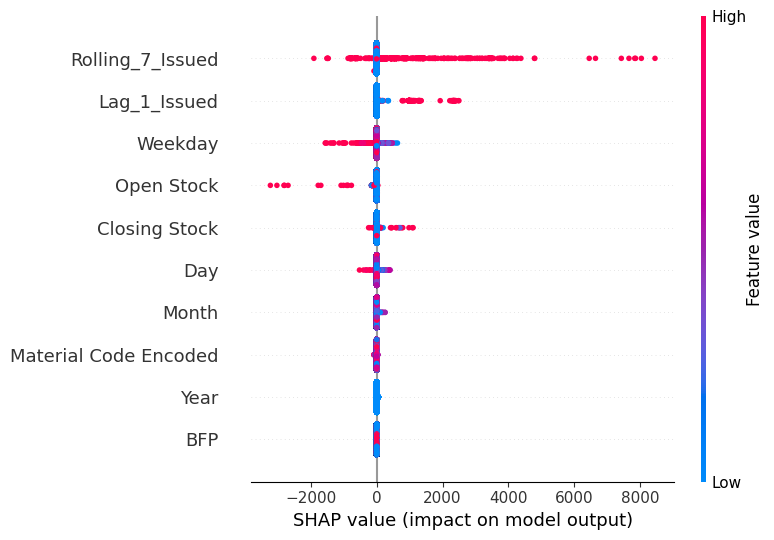

In [39]:
# SHAP analysis for Random Forest
rf_explainer = shap.Explainer(model_rf)
rf_shap_values = rf_explainer(X_test)

# Plot SHAP summary plot
shap.summary_plot(rf_shap_values, X_test)

##### Bar Plot

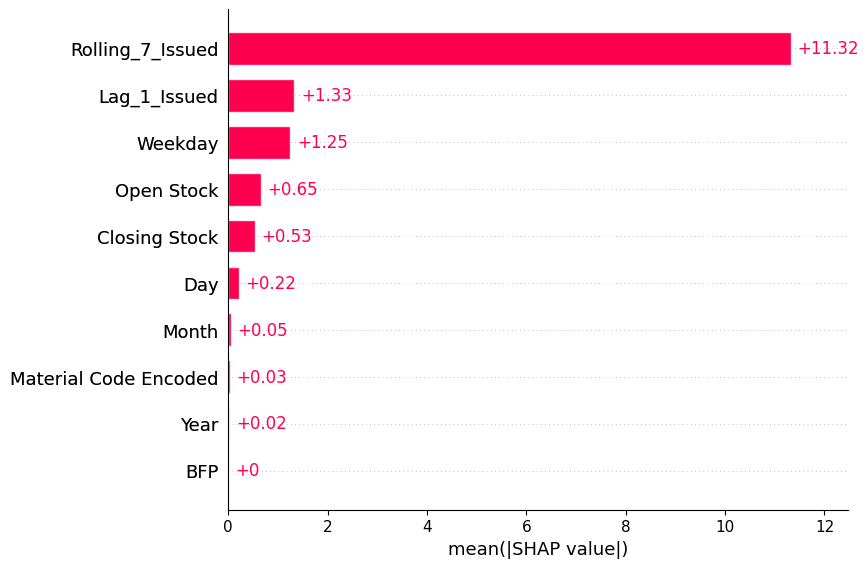

In [50]:
shap.plots.bar(rf_shap_values)

##### Force Plot

In [ ]:
# Select a single instance for the force plot
instance_index = 0
instance = X_test.iloc[instance_index]

# Create a force plot for the selected instance
shap.initjs()
shap.force_plot(rf_explainer.expected_value, rf_shap_values[instance_index].values, X_test.iloc[instance_index])

In [ ]:
shap.plots.force(rf_shap_values[:500])

##### Dependence Plot

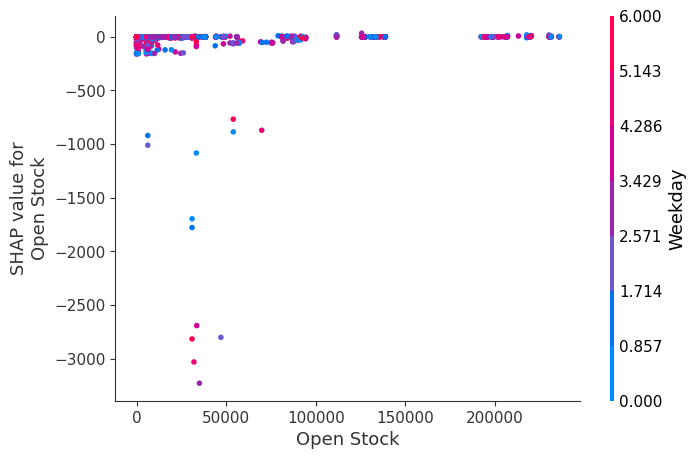

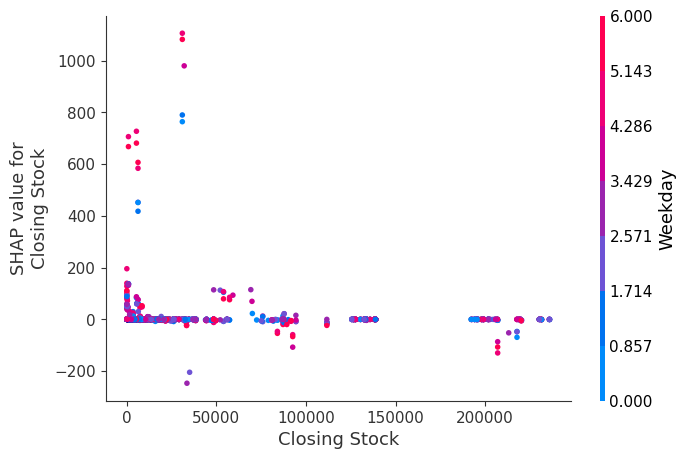

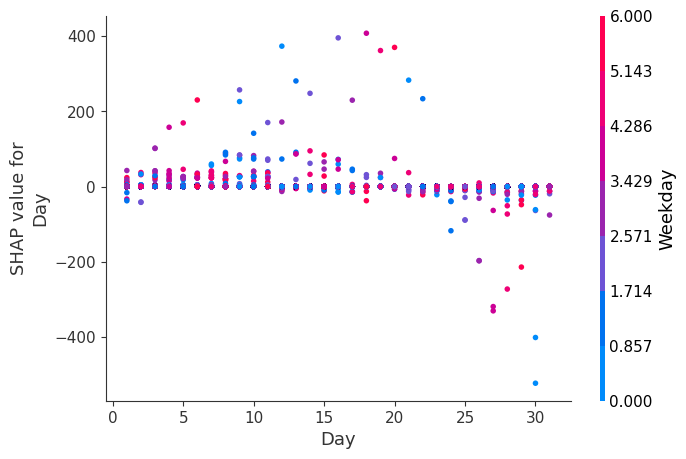

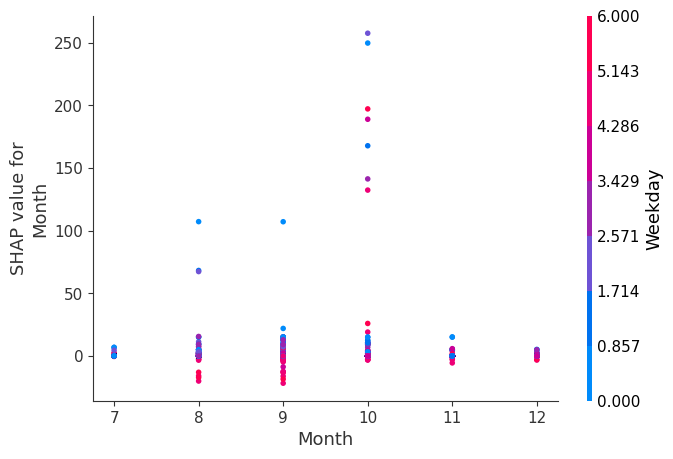

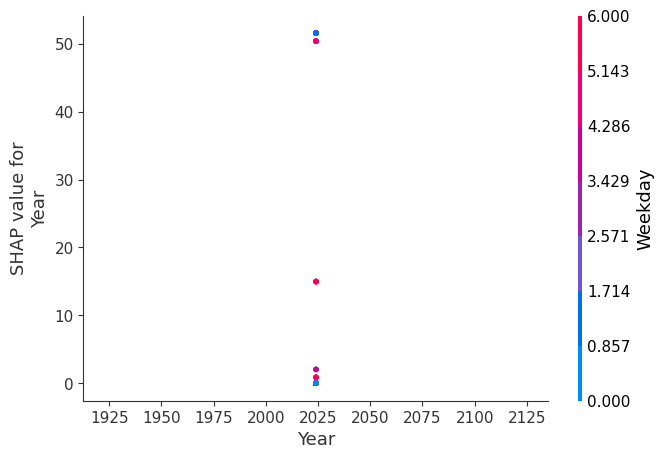

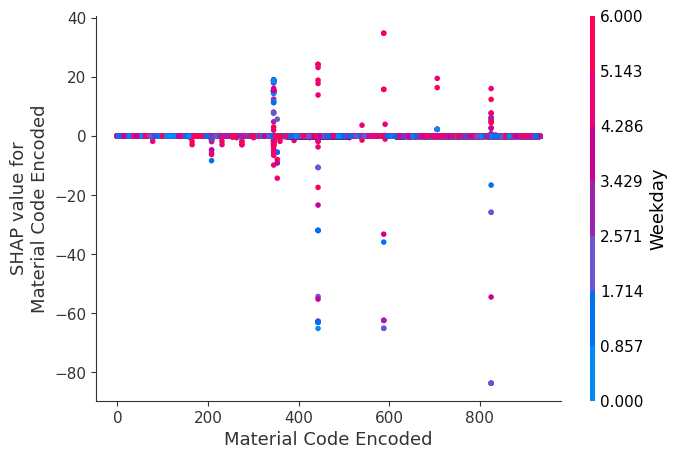

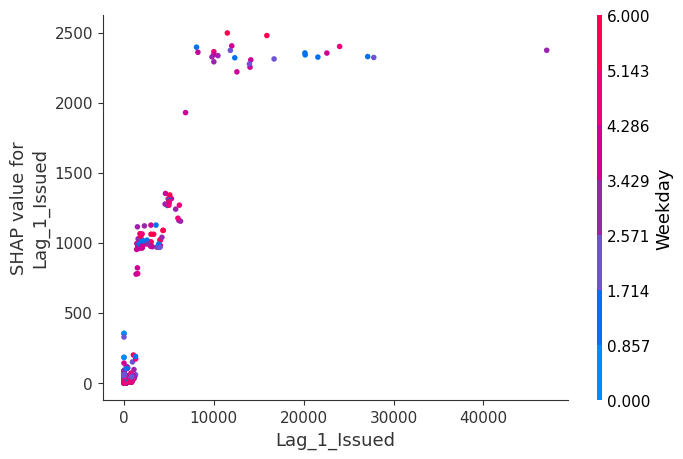

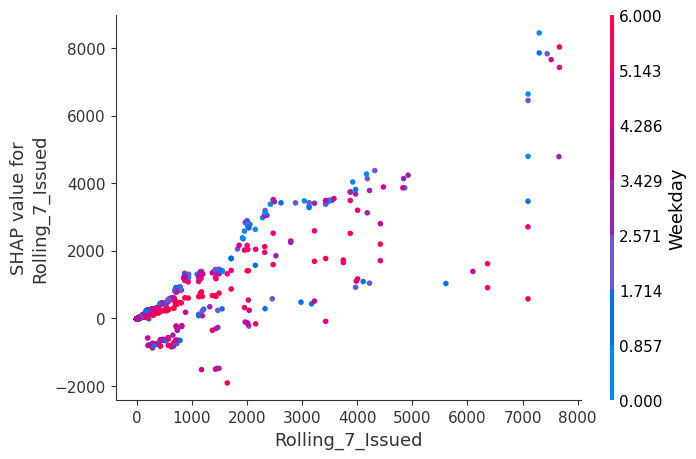

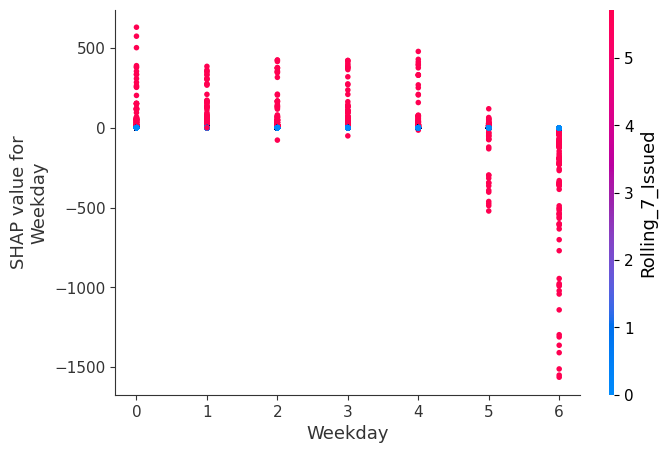

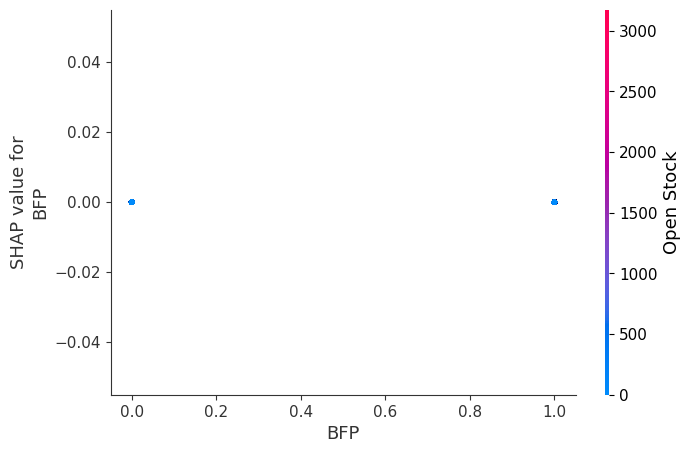

In [ ]:
for i, _ in enumerate(X_test.columns):
    shap.dependence_plot(i, rf_shap_values.values, X_test)

##### Waterfall Plot

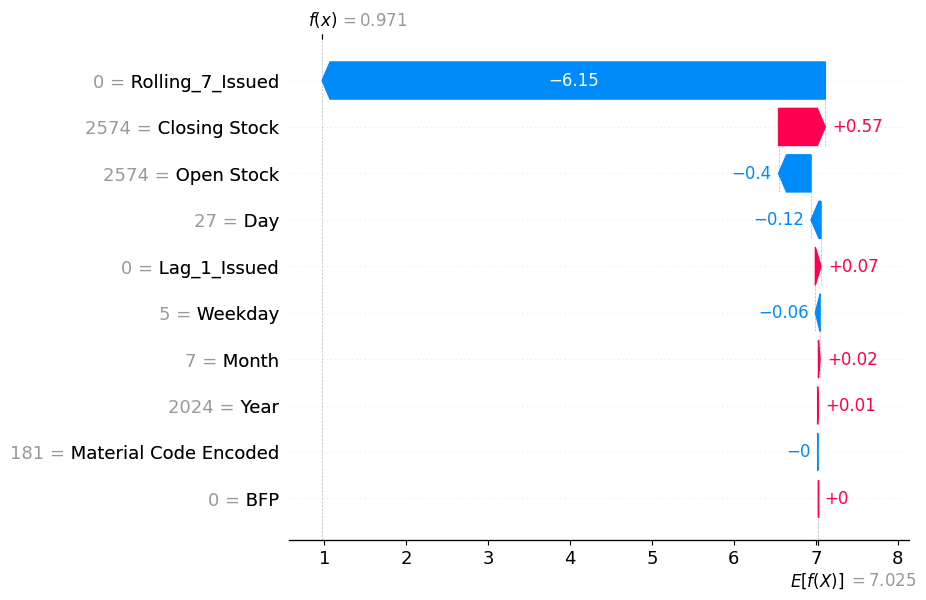

In [ ]:
# Select a single instance for the waterfall plot
instance_index = 0
instance = X_test.iloc[instance_index]

# Create a waterfall plot for the selected instance
shap.waterfall_plot(shap.Explanation(values=rf_shap_values[instance_index].values,
                                     base_values=rf_explainer.expected_value,
                                     data=X_test.iloc[instance_index]))


### XGBoost

In [62]:
# Read JSON file
with open('./best_params/xgboost_material.json', 'r') as file:
    xgboost_param = json.load(file)

In [66]:
model_xgboost = XGBRegressor(**xgboost_param)

In [67]:
model_xgboost.fit(X_train, y_train)
predictions = model_xgboost.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Best Model RMSE: {rmse}")

Best Model RMSE: 230.4123784329077


In [68]:
# Save the model as a .pkl file
model_path = "./trained_models/xgboost_model_material.pkl"
joblib.dump(model_xgboost, model_path)


['./trained_models/xgboost_model_material.pkl']

#### XGBoost Shapley

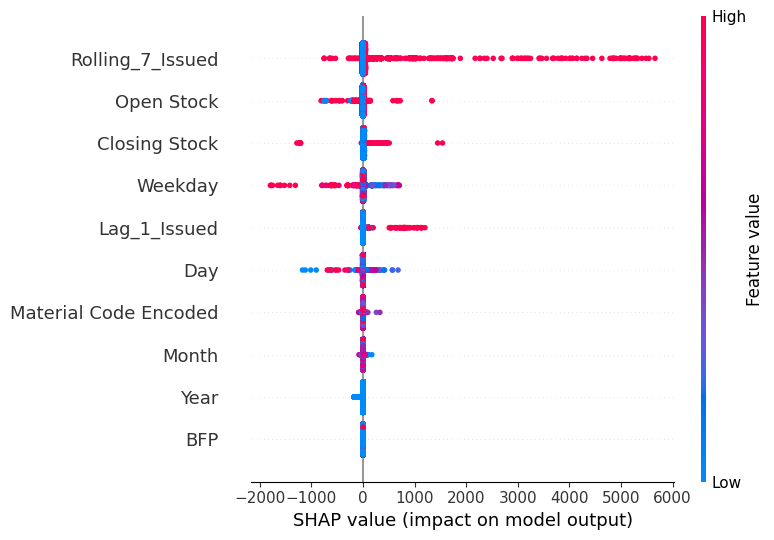

In [69]:
# SHAP analysis for Random Forest
xgb_explainer = shap.Explainer(model_xgboost)
xgb_shap_values = xgb_explainer(X_test)

# Plot SHAP summary plot
shap.summary_plot(xgb_shap_values, X_test)

##### Bar Plot

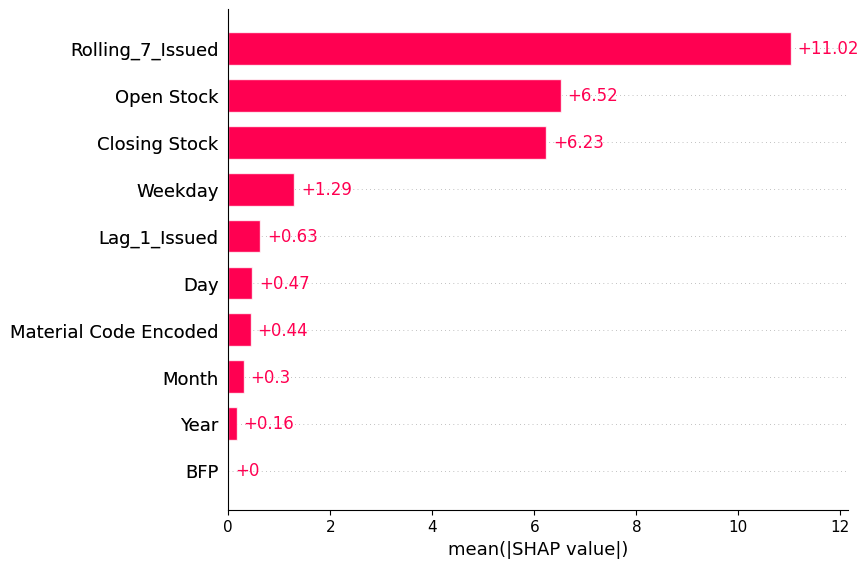

In [70]:
shap.plots.bar(xgb_shap_values)

##### Force Plot

In [72]:
# Select a single instance for the force plot
instance_index = 0
instance = X_test.iloc[instance_index]

# Create a force plot for the selected instance
shap.initjs()
shap.force_plot(xgb_explainer.expected_value, xgb_shap_values[instance_index].values, X_test.iloc[instance_index])

In [73]:
shap.plots.force(xgb_shap_values[:500])

##### Dependence Plot

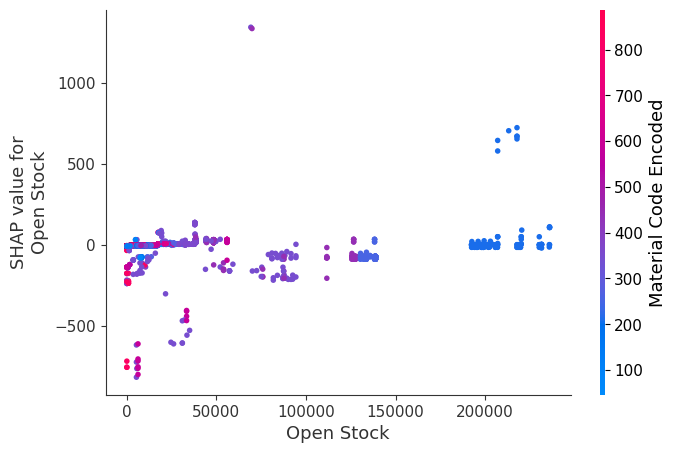

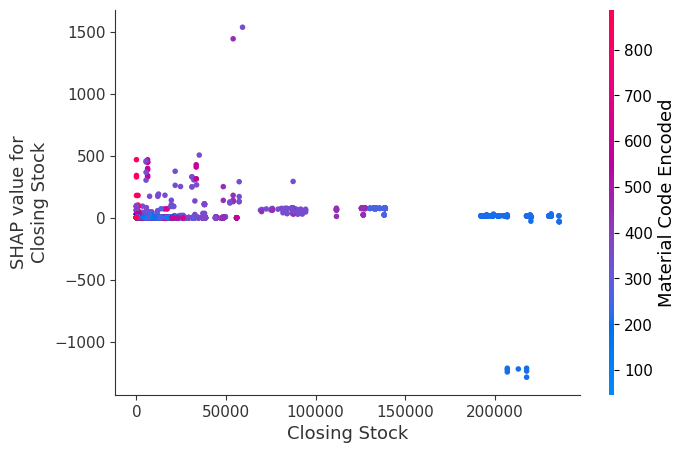

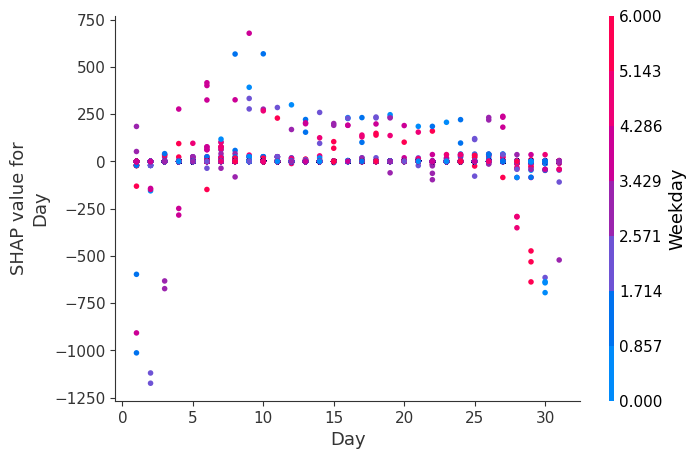

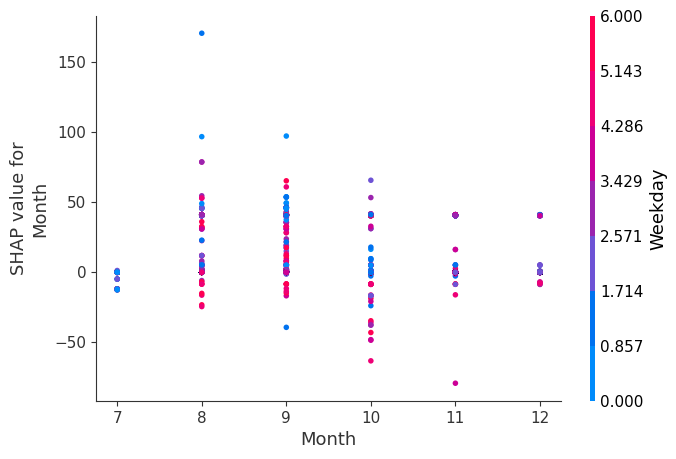

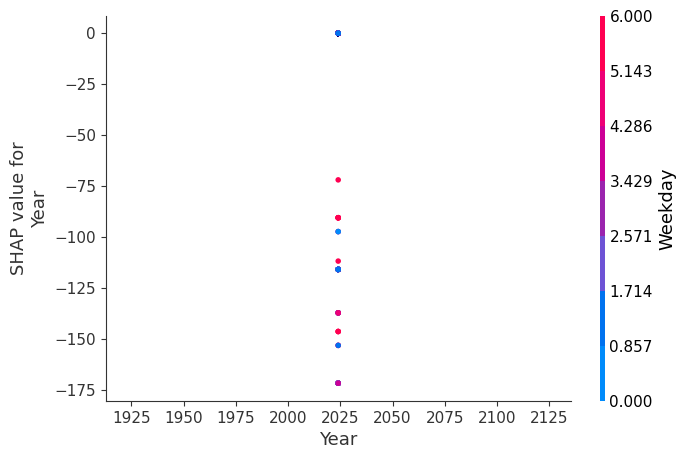

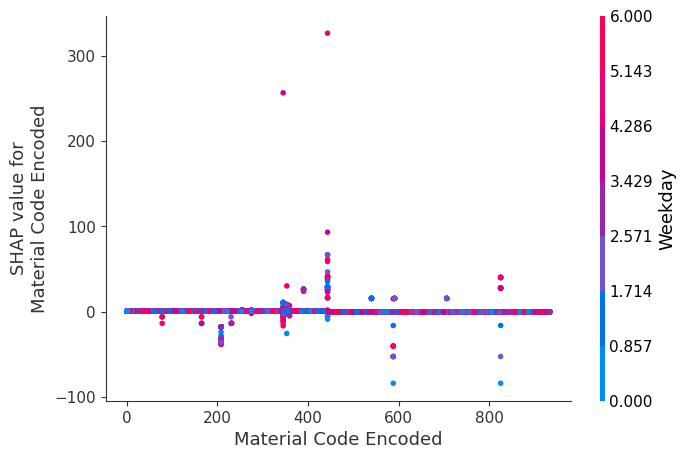

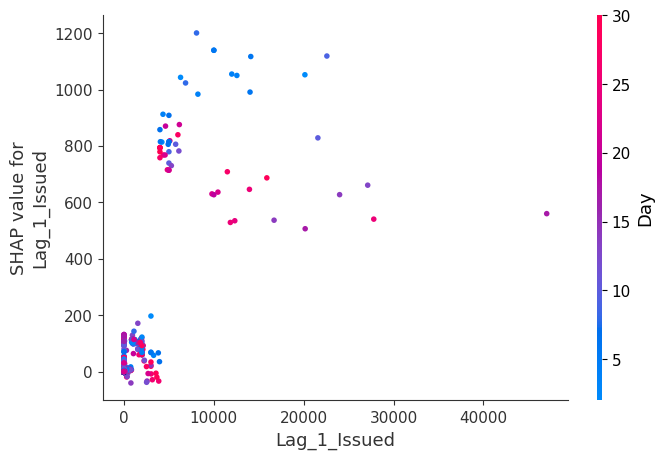

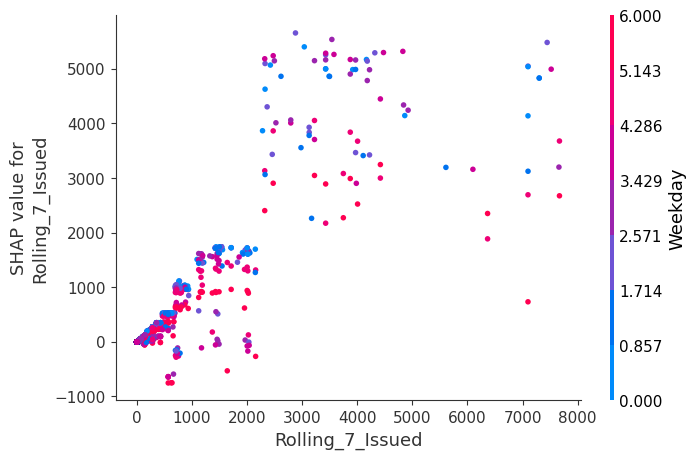

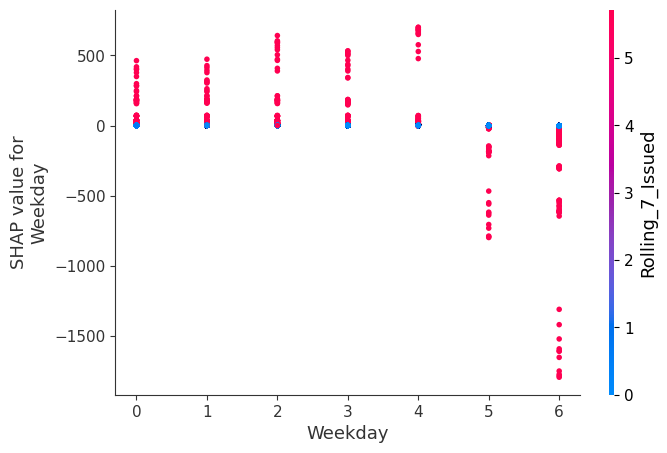

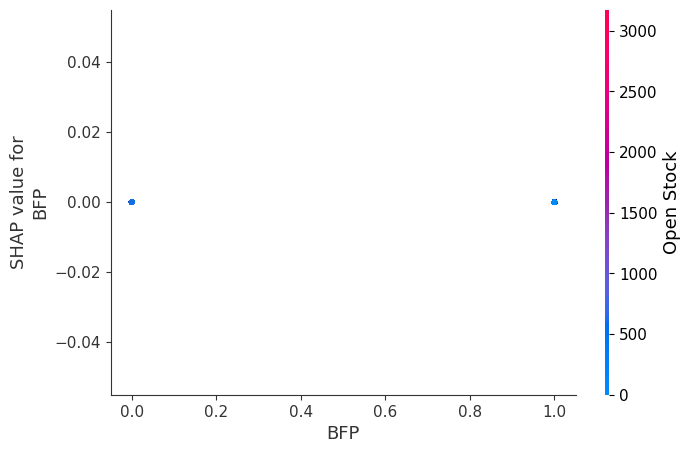

In [74]:
for i, _ in enumerate(X_test.columns):
    shap.dependence_plot(i, xgb_shap_values.values, X_test)

##### Waterfall Plot

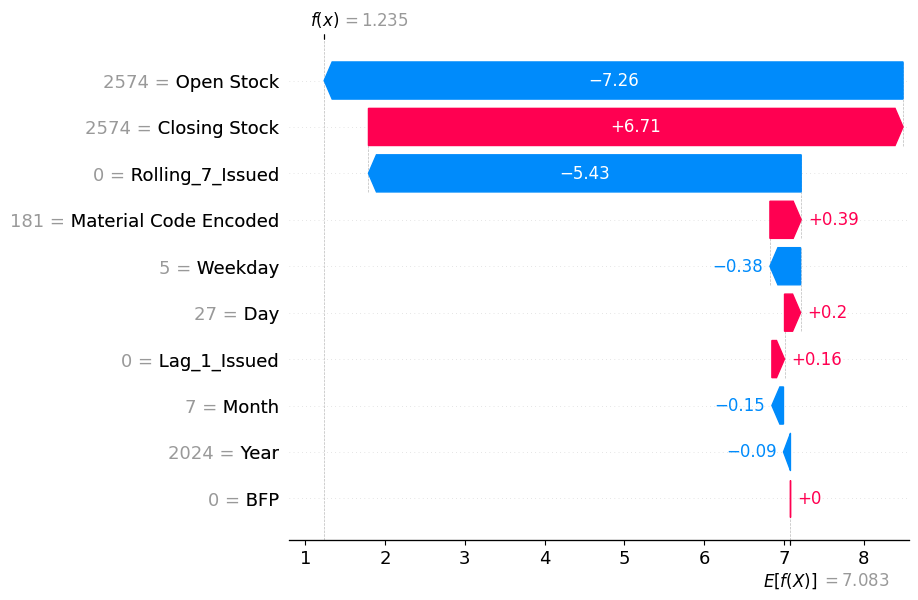

In [75]:
# Select a single instance for the waterfall plot
instance_index = 0
instance = X_test.iloc[instance_index]

# Create a waterfall plot for the selected instance
shap.waterfall_plot(shap.Explanation(values=xgb_shap_values[instance_index].values,
                                     base_values=xgb_explainer.expected_value,
                                     data=X_test.iloc[instance_index]))


### CatBoost

In [78]:
# Target and Features
features = ['Open Stock', 'Closing Stock', 'Day', 'Month', 'Year', 'Material Code', 'Lag_1_Issued', 'Rolling_7_Issued', 'Weekday', 'BFP']
X = data[features]
y = data['Material Issued']

In [79]:
# Read JSON file
with open('./best_params/catboost_material.json', 'r') as file:
    catboost_param = json.load(file)

In [82]:
model_catboost = CatBoostRegressor(**catboost_param)

In [83]:
model_catboost.fit(X_train, y_train)
predictions = model_catboost.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Best Model RMSE: {rmse}")

0:	learn: 295.0091798	total: 235ms	remaining: 42.1s
1:	learn: 291.1011564	total: 403ms	remaining: 35.8s
2:	learn: 287.6633855	total: 601ms	remaining: 35.5s
3:	learn: 283.2879520	total: 763ms	remaining: 33.6s
4:	learn: 279.7793093	total: 1.11s	remaining: 39s
5:	learn: 276.3914894	total: 1.31s	remaining: 38s
6:	learn: 273.7443292	total: 1.49s	remaining: 36.7s
7:	learn: 270.9420704	total: 1.7s	remaining: 36.6s
8:	learn: 269.0059999	total: 1.9s	remaining: 36.2s
9:	learn: 266.5244640	total: 2.06s	remaining: 35.1s
10:	learn: 263.3513683	total: 2.2s	remaining: 33.8s
11:	learn: 261.2344343	total: 2.33s	remaining: 32.7s
12:	learn: 258.9557765	total: 2.43s	remaining: 31.2s
13:	learn: 257.4161932	total: 2.55s	remaining: 30.3s
14:	learn: 255.0436954	total: 2.68s	remaining: 29.5s
15:	learn: 253.2693769	total: 2.78s	remaining: 28.5s
16:	learn: 251.7674309	total: 2.88s	remaining: 27.6s
17:	learn: 249.6442733	total: 3.06s	remaining: 27.5s
18:	learn: 247.6980499	total: 3.22s	remaining: 27.3s
19:	learn:

In [85]:
# Save the model as a .pkl file
model_path = "./trained_models/catboost_model_material.pkl"
joblib.dump(model_catboost, model_path)


['./trained_models/catboost_model_material.pkl']

#### CatBoost Shapley

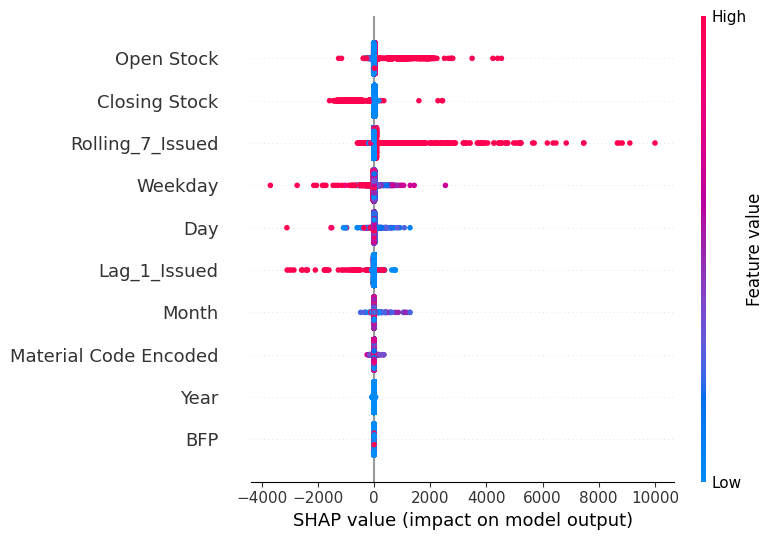

In [86]:
# SHAP analysis for Random Forest
cat_explainer = shap.Explainer(model_catboost)
cat_shap_values = cat_explainer(X_test)

# Plot SHAP summary plot
shap.summary_plot(cat_shap_values, X_test)

#### Barplot

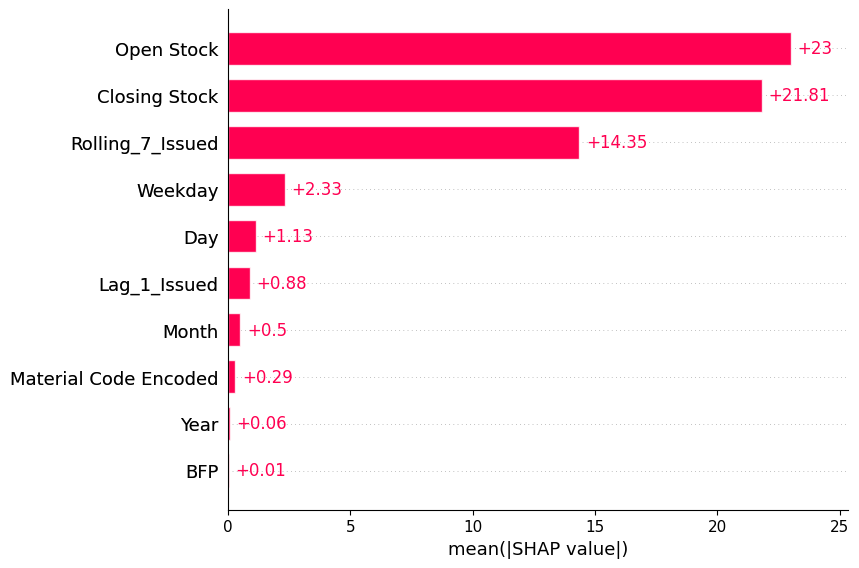

In [87]:
shap.plots.bar(cat_shap_values)

#### Force Plot

In [88]:
# Select a single instance for the force plot
instance_index = 0
instance = X_test.iloc[instance_index]

# Create a force plot for the selected instance
shap.initjs()
shap.force_plot(cat_explainer.expected_value, cat_shap_values[instance_index].values, X_test.iloc[instance_index])


In [89]:
shap.plots.force(xgb_shap_values[:500])

#### Dependence Plot

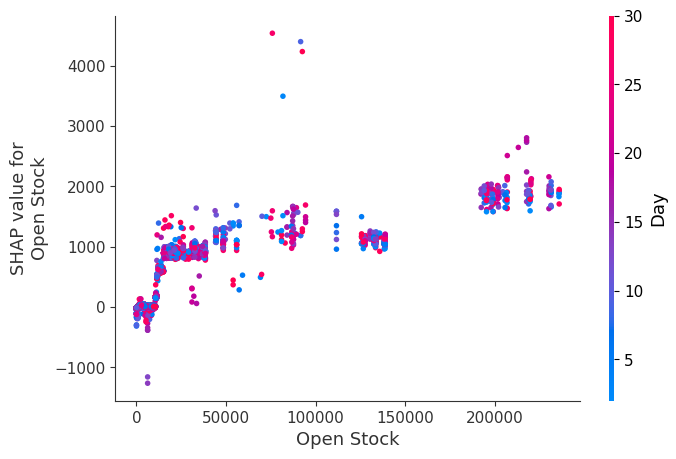

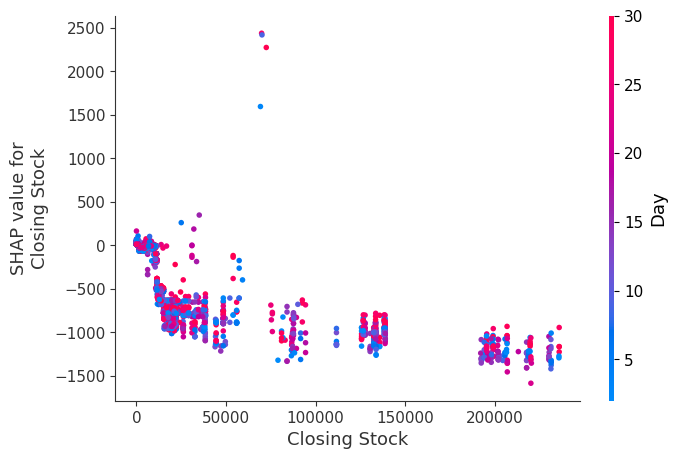

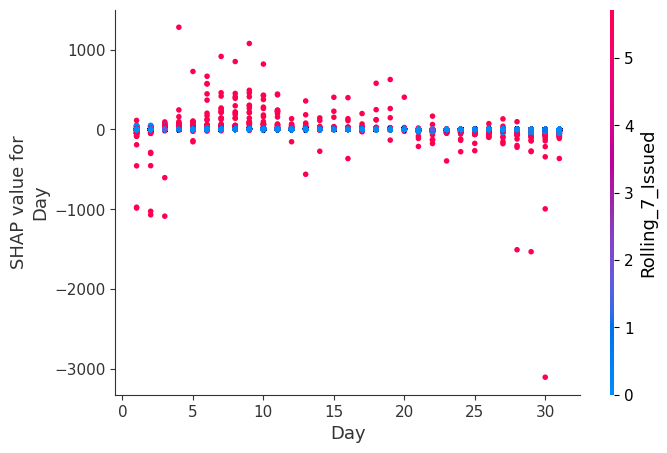

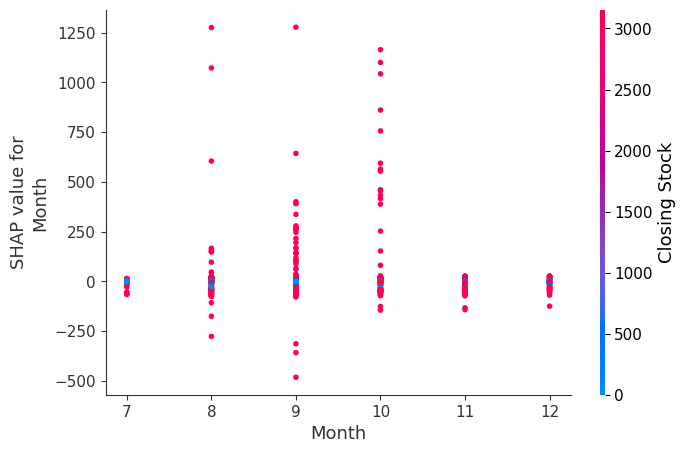

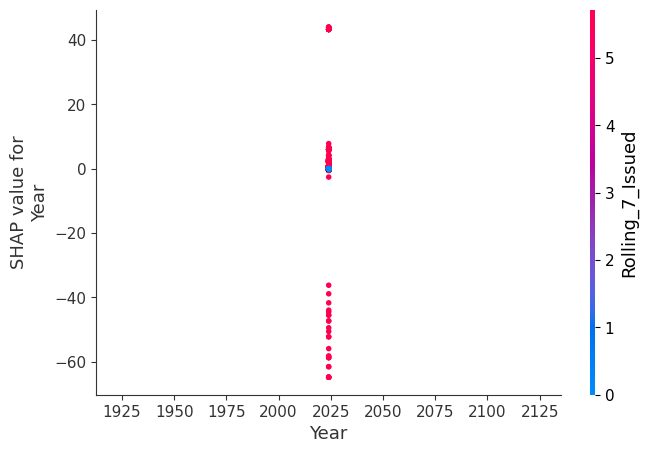

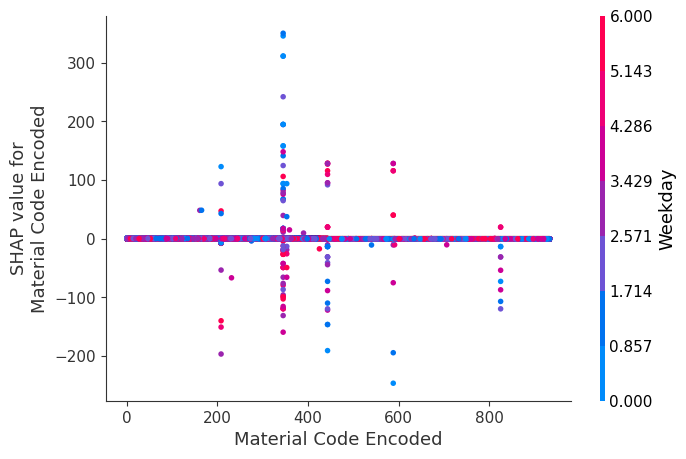

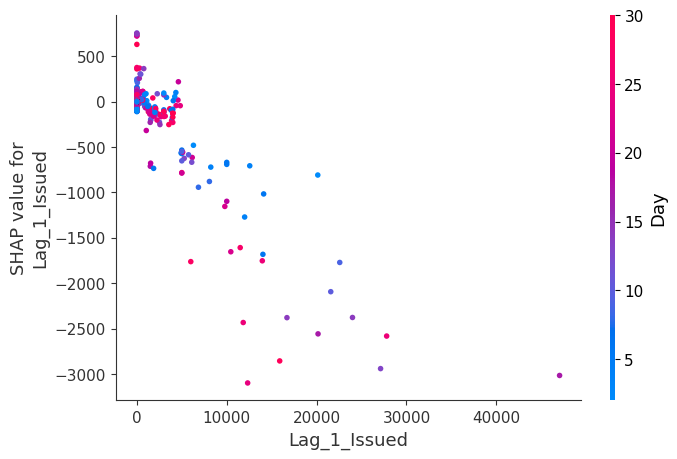

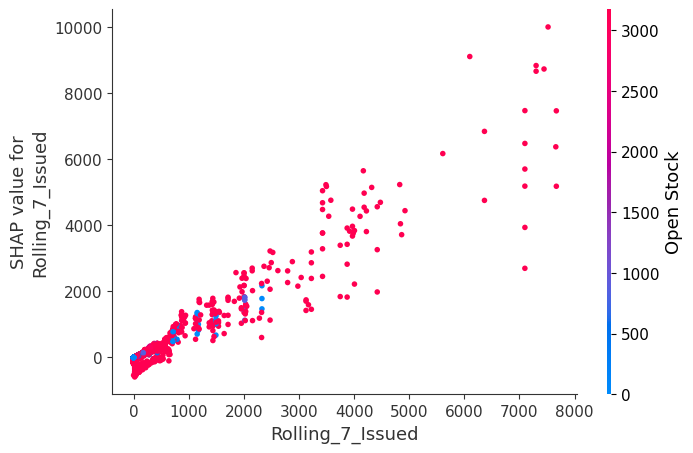

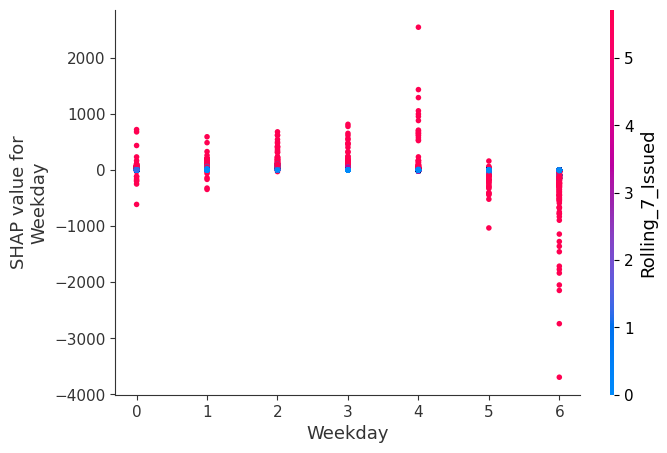

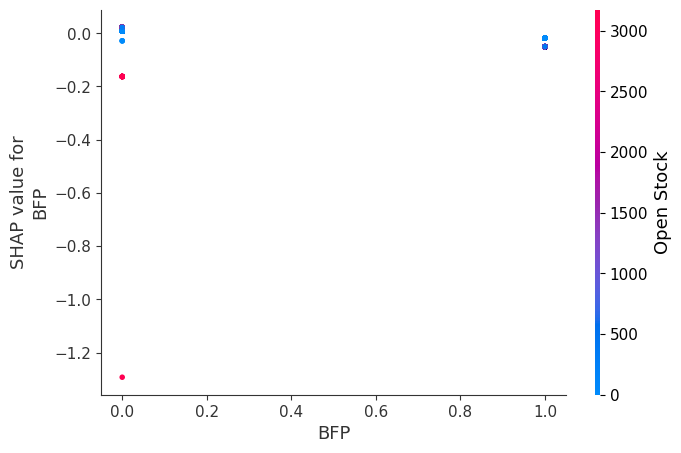

In [91]:
for i, _ in enumerate(X_test.columns):
    shap.dependence_plot(i, cat_shap_values.values, X_test)

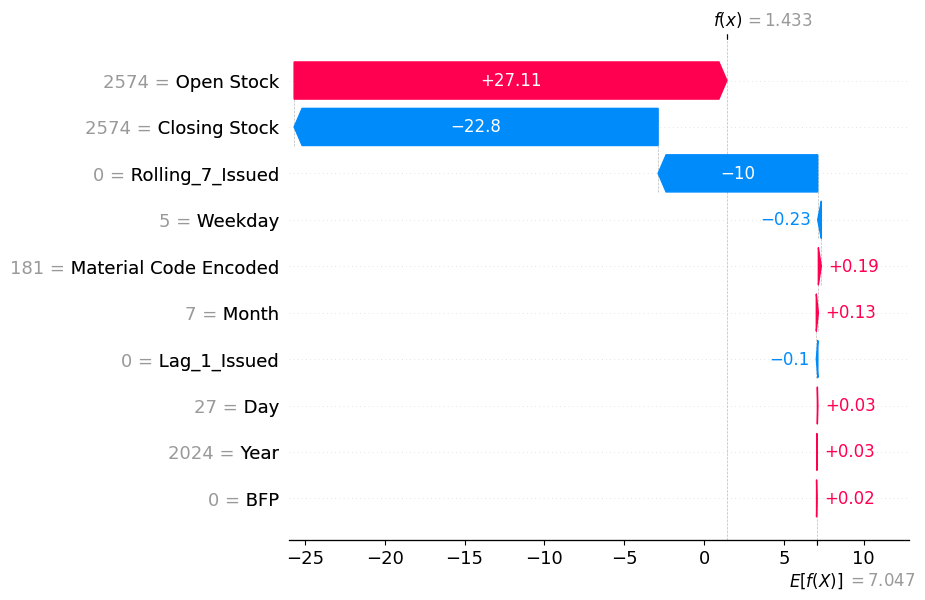

In [92]:
# Select a single instance for the waterfall plot
instance_index = 0
instance = X_test.iloc[instance_index]

# Create a waterfall plot for the selected instance
shap.waterfall_plot(shap.Explanation(values=cat_shap_values[instance_index].values,
                                     base_values=cat_explainer.expected_value,
                                     data=X_test.iloc[instance_index]))